## Low-Tubal-Rank Smoothing Tensor Completion Imputer (LSTC-Tubal)

This notebook shows how to implement a LSTC-Tubal imputer on some real-world large-scale data sets. To overcome the problem of missing values within multivariate time series data, this method takes into account both low-rank structure and time series regression. Meanwhile, to make the model scalable, we also integrate linear transform into the LATC model. For an in-depth discussion of LATC-Tubal-imputer, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Yixian Chen, Lijun Sun (2020). <b>Scalable low-rank tensor learning for spatiotemporal traffic data imputation</b>. arXiv: 2008.03194. <a href="https://arxiv.org/abs/2008.03194" title="PDF"><b>[PDF]</b></a> <a href="https://doi.org/10.5281/zenodo.3939792" title="data"><b>[data]</b></a> 
</font>
</div>


### Define LATC-imputer kernel

We start by introducing some necessary functions that relies on `Numpy`.

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>ten2mat</code>:</b> <font color="black">Unfold tensor as matrix by specifying mode.</font></li>
<li><b><code>mat2ten</code>:</b> <font color="black">Fold matrix as tensor by specifying dimension (i.e, tensor size) and mode.</font></li>
<li><b><code>svt</code>:</b> <font color="black">Implement the process of Singular Value Thresholding (SVT).</font></li>
</ul>
</div>

In [1]:
import numpy as np

def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def mat2ten(mat, dim, mode):
    index = list()
    index.append(mode)
    for i in range(dim.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(dim[index]), order = 'F'), 0, mode)

In [2]:
def unitary_transform(tensor, Phi):
    return np.einsum('kt, ijk -> ijt', Phi, tensor)

def inv_unitary_transform(tensor, Phi):
    return np.einsum('kt, ijt -> ijk', Phi, tensor)

In [3]:
def tsvt_unitary(tensor, Phi, tau):
    dim = tensor.shape
    X = np.zeros(dim)
    tensor = unitary_transform(tensor, Phi)
    for t in range(dim[2]):
        u, s, v = np.linalg.svd(tensor[:, :, t], full_matrices = False)
        r = len(np.where(s > tau)[0])
        if r >= 1:
            s = s[: r]
            s[: r] = s[: r] - tau
            X[:, :, t] = u[:, : r] @ np.diag(s) @ v[: r, :]
    return inv_unitary_transform(X, Phi)

from scipy.fftpack import dctn, idctn

def tsvt_dct(tensor, tau):
    dim = tensor.shape
    X = np.zeros(dim)
    tensor = dctn(tensor, axes = (2,), norm = 'ortho')
    for t in range(dim[2]):
        u, s, v = np.linalg.svd(tensor[:, :, t], full_matrices = False)
        r = len(np.where(s > tau)[0])
        if r >= 1:
            s = s[: r]
            s[: r] = s[: r] - tau
            X[:, :, t] = u[:, : r] @ np.diag(s) @ v[: r, :]
    return idctn(X, axes = (2,), norm = 'ortho')

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>compute_mape</code>:</b> <font color="black">Compute the value of Mean Absolute Percentage Error (MAPE).</font></li>
<li><b><code>compute_rmse</code>:</b> <font color="black">Compute the value of Root Mean Square Error (RMSE).</font></li>
</ul>
</div>

> Note that $$\mathrm{MAPE}=\frac{1}{n} \sum_{i=1}^{n} \frac{\left|y_{i}-\hat{y}_{i}\right|}{y_{i}} \times 100, \quad\mathrm{RMSE}=\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}},$$ where $n$ is the total number of estimated values, and $y_i$ and $\hat{y}_i$ are the actual value and its estimation, respectively.

In [4]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

The main idea behind LATC-imputer is to approximate partially observed data with both low-rank structure and time series dynamics. The following `imputer` kernel includes some necessary inputs:

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>dense_tensor</code>:</b> <font color="black">This is an input which has the ground truth for validation. If this input is not available, you could use <code>dense_tensor = sparse_tensor.copy()</code> instead.</font></li>
<li><b><code>sparse_tensor</code>:</b> <font color="black">This is a partially observed tensor which has many missing entries.</font></li>
<li><b><code>time_lags</code>:</b> <font color="black">Time lags, e.g., <code>time_lags = np.array([1, 2, 3])</code>. </font></li>
<li><b><code>alpha</code>:</b> <font color="black">Weights for tensors' nuclear norm, e.g., <code>alpha = np.ones(3) / 3</code>. </font></li>
<li><b><code>rho</code>:</b> <font color="black">Learning rate for ADMM, e.g., <code>rho = 0.0005</code>. </font></li>
<li><b><code>lambda0</code>:</b> <font color="black">Weight for time series regressor, e.g., <code>lambda0 = 5 * rho</code>. If <code>lambda0 = 0</code>, then this imputer is actually a standard low-rank tensor completion (i.e., High-accuracy Low-Rank Tensor Completion, or HaLRTC).</font></li>
<li><b><code>epsilon</code>:</b> <font color="black">Stop criteria, e.g., <code>epsilon = 0.001</code>. </font></li>
<li><b><code>maxiter</code>:</b> <font color="black">Maximum iteration to stop algorithm, e.g., <code>maxiter = 50</code>. </font></li>
</ul>
</div>


In [5]:
def imputer(dense_tensor, sparse_tensor, rho0, lambda0, epsilon, maxiter, transform = "unitary"):
    """Low-Tubal-Rank Smoothing Tensor Completion, LSTC-Tubal-imputer."""
    
    dim = np.array(sparse_tensor.shape)
    dt = np.int(np.prod(dim) / dim[0])
    sparse_mat = ten2mat(sparse_tensor, 0)
    pos_missing = np.where(sparse_mat == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    var = dense_tensor[pos_test]
    
    T = np.zeros(dim)                         # \boldsymbol{\mathcal{T}}
    Z_tensor = sparse_tensor.copy()           # \boldsymbol{\mathcal{Z}}
    Z_tensor[Z_tensor == 0] = np.mean(sparse_tensor[sparse_tensor != 0])
    Z = sparse_mat.copy()                     # \boldsymbol{Z}
    it = 0
    last_mat = sparse_mat.copy()
    snorm = np.linalg.norm(sparse_mat, 'fro')
    del dense_tensor, sparse_tensor, sparse_mat
    rho = rho0
    Phis = []
    if transform == "unitary":
        temp1 = ten2mat(Z_tensor, 2)
        _, Phi = np.linalg.eig(temp1 @ temp1.T)
        Phis.append(Phi)
        del temp1
    if lambda0 > 0:
        from scipy import sparse
        from scipy.sparse.linalg import inv as inv
        from scipy.sparse.linalg import spsolve as spsolve
        Psi1 = sparse.coo_matrix((np.ones(dt - 1), (np.arange(0, dt - 1), np.arange(0, dt - 1))), 
                                 shape = (dt - 1, dt)).tocsr()
        Psi2 = sparse.coo_matrix((np.ones(dt - 1), (np.arange(0, dt - 1), np.arange(0, dt - 1) + 1)), 
                                 shape = (dt - 1, dt)).tocsr()
        temp0 = Psi2 - Psi1
        Imat = sparse.coo_matrix((np.ones(dt), (np.arange(0, dt), np.arange(0, dt))), shape = (dt, dt)).tocsr()
        const = lambda0 * temp0.T @ temp0
        del Psi1, Psi2, temp0
    while True:
        rho = min(rho * 1.05, 1e5)
        if transform == "unitary":
            X = tsvt_unitary(Z_tensor - T / rho, Phi, 1 / rho)
        elif transform == "dct":
            X = tsvt_dct(Z_tensor - T / rho, 1 / rho)
        mat_hat = ten2mat(X, 0)
        temp = ten2mat(X + T / rho, 0)
        if lambda0 > 0:
            Z[pos_missing] = (spsolve(const / rho + Imat, temp.T).T)[pos_missing]
        elif lambda0 == 0:
            Z[pos_missing] = temp[pos_missing]
        Z_tensor = mat2ten(Z, dim, 0)
        T = T + rho * (X - Z_tensor)
        tol = np.linalg.norm((mat_hat - last_mat), 'fro') / snorm
        last_mat = mat_hat.copy()
        it += 1
        if it % 10 == 0:
            if transform == "unitary":
                temp1 = ten2mat(Z_tensor - T / rho, 2)
                _, Phi = np.linalg.eig(temp1 @ temp1.T)
                Phis.append(Phi)
                del temp1
        if it % 5 == 0:
            print('Iter: {}'.format(it))
            print('Tolerance: {:.6}'.format(tol))
            print('MAPE: {:.6}'.format(compute_mape(var, X[pos_test])))
            print('RMSE: {:.6}'.format(compute_rmse(var, X[pos_test])))
            print()
        if (tol < epsilon) or (it >= maxiter):
            break

    print('Total iteration: {}'.format(it))
    print('Tolerance: {:.6}'.format(tol))
    print('Imputation MAPE: {:.6}'.format(compute_mape(var, X[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(var, X[pos_test])))
    print()
    
    return X, Phis

## Test Model with Graph Partitioning

We use the following codes to generate graph partitioning scheme.

```python
import pickle
import numpy as np
import pymetis
import pandas as pd

def load_graph_data(pkl_filename):
    sensor_ids, sensor_id_to_ind, adj_mx = load_pickle(pkl_filename)
    return sensor_ids, sensor_id_to_ind, adj_mx

def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data

if __name__ == '__main__':
    sid, sind, adj = load_graph_data('adj_mat.pkl')
    print(adj.shape)
    adj_lst = []
    part_pems = pd.DataFrame()
    for i in range(len(adj)):
        idx = np.setdiff1d(np.where(adj[i,:] > 0)[0], np.array([i]))
        adj_lst.append(idx)
    for k in [2, 4, 8, 16, 32, 64]:
        cuts, labels = pymetis.part_graph(k, adjacency=adj_lst)
        print(set(labels))
        part_pems[str(k)] = labels
    part_pems.to_csv('../datasets/California-data-set/graph_pems.csv', index=False)
```

In [6]:
import pandas as pd

graph_pems = pd.read_csv('../datasets/California-data-set/graph_pems.csv')
graph_pems.head()

,2,4,8,16,32,64
0,0,1,2,6,5,47
1,0,1,2,6,5,47
2,0,1,2,6,5,47
3,0,1,2,6,5,47
4,0,1,2,6,5,47


In [ ]:
import numpy as np
import pandas as pd
np.random.seed(1000)

data = pd.read_csv('../datasets/California-data-set/pems-4w.csv', header = None)
dense_tensor = mat2ten(data.values, np.array([data.values.shape[0], 288, 4 * 7]), 0)
random_tensor = np.random.rand(data.values.shape[0], 288, 4 * 7)

missing_rate = 0.3

### Random missing (RM)
sparse_tensor = dense_tensor * np.round(random_tensor + 0.5 - missing_rate)
del data, random_tensor

## Test LSTC-Tubal Model
epsilon = 1e-3
maxiter = 100
pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
var = dense_tensor[pos_test]
mape = np.zeros((7, 3, 3))
rmse = np.zeros((7, 3, 3))

for i in range(1, 7):
    print('Graph partitioning: {}.'.format(2 ** i))
    j = 0
    for rho in [1e-3, 5e-3, 1e-2]:
        k = 0
        for c in [1e-3, 1e-2, 1e-1]:
            lambda0 = c * rho
            tensor_hat = np.zeros(dense_tensor.shape)
            if i == 0:
                tensor_hat, _ = imputer(dense_tensor, sparse_tensor, rho, lambda0, epsilon, maxiter)
                mape[i, j, k] = compute_mape(var, tensor_hat[pos_test])
                rmse[i, j, k] = compute_rmse(var, tensor_hat[pos_test])
            else:
                road = graph_pems.values[:, i - 1]
                for d in range(2 ** i):
                    pos = np.where(road == d)
                    dense = dense_tensor[pos[0], :, :]
                    sparse = sparse_tensor[pos[0], :, :]
                    small_tensor, _ = imputer(dense, sparse, rho, lambda0, epsilon, maxiter)
                    tensor_hat[pos[0], :, :] = small_tensor
                mape[i, j, k] = compute_mape(var, tensor_hat[pos_test])
                rmse[i, j, k] = compute_rmse(var, tensor_hat[pos_test])
            k += 1
        j += 1
    print('Final MAPE:')
    print(mape[i, :, :])
    print('Final RMSE:')
    print(rmse[i, :, :])
    print()

In [7]:
import numpy as np
import pandas as pd
np.random.seed(1000)

data = pd.read_csv('../datasets/California-data-set/pems-4w.csv', header = None)
dense_tensor = mat2ten(data.values, np.array([data.values.shape[0], 288, 4 * 7]), 0)
random_tensor = np.random.rand(data.values.shape[0], 288, 4 * 7)

missing_rate = 0.7

### Random missing (RM)
sparse_tensor = dense_tensor * np.round(random_tensor + 0.5 - missing_rate)
del data, random_tensor

## Test LSTC-Tubal Model
epsilon = 1e-3
maxiter = 100
pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
var = dense_tensor[pos_test]
mape = np.zeros((7, 3, 3))
rmse = np.zeros((7, 3, 3))

for i in range(1, 7):
    print('Graph partitioning: {}.'.format(2 ** i))
    j = 0
    for rho in [1e-3, 5e-3, 1e-2]:
        k = 0
        for c in [1e-3, 1e-2, 1e-1]:
            lambda0 = c * rho
            tensor_hat = np.zeros(dense_tensor.shape)
            if i == 0:
                tensor_hat, _ = imputer(dense_tensor, sparse_tensor, rho, lambda0, epsilon, maxiter)
                mape[i, j, k] = compute_mape(var, tensor_hat[pos_test])
                rmse[i, j, k] = compute_rmse(var, tensor_hat[pos_test])
            else:
                road = graph_pems.values[:, i - 1]
                for d in range(2 ** i):
                    pos = np.where(road == d)
                    dense = dense_tensor[pos[0], :, :]
                    sparse = sparse_tensor[pos[0], :, :]
                    small_tensor, _ = imputer(dense, sparse, rho, lambda0, epsilon, maxiter)
                    tensor_hat[pos[0], :, :] = small_tensor
                mape[i, j, k] = compute_mape(var, tensor_hat[pos_test])
                rmse[i, j, k] = compute_rmse(var, tensor_hat[pos_test])
            k += 1
        j += 1
    print('Final MAPE:')
    print(mape[i, :, :])
    print('Final RMSE:')
    print(rmse[i, :, :])
    print()

Graph partitioning: 2.
Final MAPE:
[[0.02559145 0.02571864 0.02736457]
 [0.02708789 0.02683288 0.02586238]
 [0.0375385  0.03402267 0.02667263]]
Final RMSE:
[[2.31571756 2.3258735  2.45977911]
 [2.39595626 2.38275551 2.34027128]
 [3.10134414 2.85772349 2.39697255]]

Graph partitioning: 4.
Final MAPE:
[[0.02677744 0.02686362 0.02805694]
 [0.02688619 0.02709273 0.02719683]
 [0.03170744 0.03010276 0.02658389]]
Final RMSE:
[[2.38256761 2.3902771  2.49259745]
 [2.38454787 2.39752796 2.42177358]
 [2.66629699 2.56699648 2.36706632]]

Graph partitioning: 8.
Final MAPE:
[[0.02816056 0.02820276 0.02877879]
 [0.02795911 0.02783353 0.02805369]
 [0.03015453 0.02923842 0.02681856]]
Final RMSE:
[[2.469719   2.4739894  2.53136567]
 [2.45511797 2.44814194 2.47857669]
 [2.56836319 2.51259293 2.37408279]]

Graph partitioning: 16.
Final MAPE:
[[0.02983293 0.02974203 0.02947013]
 [0.02976859 0.02961283 0.02909988]
 [0.03041097 0.02981774 0.02788668]]
Final RMSE:
[[2.58549285 2.58015406 2.57307289]
 [2.58148

In [ ]:
import numpy as np
import pandas as pd
np.random.seed(1000)

data = pd.read_csv('../datasets/California-data-set/pems-4w.csv', header = None)
dense_tensor = mat2ten(data.values, np.array([data.values.shape[0], 288, 4 * 7]), 0)
random_matrix = np.random.rand(data.values.shape[0], 4 * 7)

missing_rate = 0.3

### Non-random missing (NM) scenario:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[2]):
        binary_tensor[i1, :, i2] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)
del data, random_matrix, binary_tensor

## Test LSTC-Tubal Model
epsilon = 1e-3
maxiter = 100
pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
var = dense_tensor[pos_test]
mape = np.zeros((7, 5, 3))
rmse = np.zeros((7, 5, 3))

for i in range(1, 7):
    print('Graph partitioning: {}.'.format(2 ** i))
    j = 0
    for rho in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]:
        k = 0
        for c in [1e-3, 1e-2, 1e-1]:
            lambda0 = c * rho
            tensor_hat = np.zeros(dense_tensor.shape)
            if i == 0:
                tensor_hat, _ = imputer(dense_tensor, sparse_tensor, rho, lambda0, epsilon, maxiter)
                mape[i, j, k] = compute_mape(var, tensor_hat[pos_test])
                rmse[i, j, k] = compute_rmse(var, tensor_hat[pos_test])
            else:
                road = graph_pems.values[:, i - 1]
                for d in range(2 ** i):
                    pos = np.where(road == d)
                    dense = dense_tensor[pos[0], :, :]
                    sparse = sparse_tensor[pos[0], :, :]
                    small_tensor, _ = imputer(dense, sparse, rho, lambda0, epsilon, maxiter)
                    tensor_hat[pos[0], :, :] = small_tensor
                mape[i, j, k] = compute_mape(var, tensor_hat[pos_test])
                rmse[i, j, k] = compute_rmse(var, tensor_hat[pos_test])
            k += 1
        j += 1
    print('Final MAPE:')
    print(mape[i, :, :])
    print('Final RMSE:')
    print(rmse[i, :, :])
    print()

In [7]:
import numpy as np
import pandas as pd
np.random.seed(1000)

data = pd.read_csv('../datasets/California-data-set/pems-4w.csv', header = None)
dense_tensor = mat2ten(data.values, np.array([data.values.shape[0], 288, 4 * 7]), 0)
random_matrix = np.random.rand(data.values.shape[0], 4 * 7)

missing_rate = 0.7

### Non-random missing (NM) scenario:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[2]):
        binary_tensor[i1, :, i2] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)
del data, random_matrix, binary_tensor

## Test LSTC-Tubal Model
epsilon = 1e-3
maxiter = 100
pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
var = dense_tensor[pos_test]
mape = np.zeros((7, 5, 3))
rmse = np.zeros((7, 5, 3))

for i in range(1, 7):
    print('Graph partitioning: {}.'.format(2 ** i))
    j = 0
    for rho in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]:
        k = 0
        for c in [1e-3, 1e-2, 1e-1]:
            lambda0 = c * rho
            tensor_hat = np.zeros(dense_tensor.shape)
            if i == 0:
                tensor_hat, _ = imputer(dense_tensor, sparse_tensor, rho, lambda0, epsilon, maxiter)
                mape[i, j, k] = compute_mape(var, tensor_hat[pos_test])
                rmse[i, j, k] = compute_rmse(var, tensor_hat[pos_test])
            else:
                road = graph_pems.values[:, i - 1]
                for d in range(2 ** i):
                    pos = np.where(road == d)
                    dense = dense_tensor[pos[0], :, :]
                    sparse = sparse_tensor[pos[0], :, :]
                    small_tensor, _ = imputer(dense, sparse, rho, lambda0, epsilon, maxiter)
                    tensor_hat[pos[0], :, :] = small_tensor
                mape[i, j, k] = compute_mape(var, tensor_hat[pos_test])
                rmse[i, j, k] = compute_rmse(var, tensor_hat[pos_test])
            k += 1
        j += 1
    print('Final MAPE:')
    print(mape[i, :, :])
    print('Final RMSE:')
    print(rmse[i, :, :])
    print()

Graph partitioning: 2.
Final MAPE:
[[0.06570153 0.06569398 0.06592662]
 [0.06584572 0.0658576  0.06615824]
 [0.07045194 0.0704494  0.07058429]
 [0.10147306 0.10145809 0.10136028]
 [0.11167958 0.11166415 0.11171363]]
Final RMSE:
[[5.05256578 5.05177715 5.06717345]
 [5.0551596  5.05562288 5.07327965]
 [5.31447771 5.31444403 5.32359923]
 [7.30792329 7.30736666 7.30436327]
 [7.95196926 7.95126142 7.9567187 ]]

Graph partitioning: 4.
Final MAPE:
[[0.06516804 0.06516218 0.06531031]
 [0.06510132 0.06510016 0.06527516]
 [0.06705867 0.06705667 0.06736163]
 [0.09478097 0.09483806 0.09496056]
 [0.10782678 0.10780571 0.10792663]]
Final RMSE:
[[5.02221131 5.02110703 5.03066459]
 [5.01727421 5.01721791 5.0288955 ]
 [5.11350821 5.11342922 5.13103288]
 [6.89344134 6.8970904  6.90767343]
 [7.70151374 7.70050059 7.71076656]]

Graph partitioning: 8.
Final MAPE:
[[0.06452292 0.06452317 0.0644468 ]
 [0.06434369 0.06431707 0.06449677]
 [0.06491473 0.06491194 0.06502643]
 [0.0864302  0.08643025 0.08708411]
 

In [79]:
def tsvt_unitary(tensor, Phi, tau):
    dim = tensor.shape
    X = np.zeros(dim)
    tensor = unitary_transform(tensor, Phi)
    sv = np.zeros((min(dim[0], dim[1]), dim[2]))
    for t in range(dim[2]):
        u, s, v = np.linalg.svd(tensor[:, :, t], full_matrices = False)
        sv[:, t] = s
        r = len(np.where(s > tau)[0])
        if r >= 1:
            s = s[: r]
            s[: r] = s[: r] - tau
            X[:, :, t] = u[:, : r] @ np.diag(s) @ v[: r, :]
    return inv_unitary_transform(X, Phi), sv

def imputer(dense_tensor, sparse_tensor, rho0, lambda0, epsilon, maxiter, 
            sparse_Psi = True, transform = "unitary"):
    """Low-Tubal-Rank Smoothing Tensor Completion, LSTC-Tubal-imputer."""
    
    dim = np.array(sparse_tensor.shape)
    dt = np.int(np.prod(dim) / dim[0])
    sparse_mat = ten2mat(sparse_tensor, 0)
    pos_missing = np.where(sparse_mat == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    var = dense_tensor[pos_test]
    
    T = np.zeros(dim)                         # \boldsymbol{\mathcal{T}}
    Z = sparse_mat.copy()                     # \boldsymbol{Z}
    Z[pos_missing] = np.mean(sparse_mat[sparse_mat != 0])
    it = 0
    last_mat = sparse_mat.copy()
    snorm = np.linalg.norm(sparse_mat, 'fro')
    del dense_tensor, sparse_tensor, sparse_mat
    rho = rho0
    Phis = []
    if transform == "unitary":
        temp1 = ten2mat(mat2ten(Z, dim, 0), 2)
        _, Phi = np.linalg.eig(temp1 @ temp1.T)
        Phis.append(Phi)
        del temp1
    if lambda0 > 0:
        if sparse_Psi == True:
            from scipy import sparse
            from scipy.sparse.linalg import inv as inv
            Psi1 = sparse.coo_matrix((np.ones(dt - 1), (np.arange(0, dt - 1), np.arange(0, dt - 1))), 
                                     shape = (dt - 1, dt)).tocsr()
            Psi2 = sparse.coo_matrix((np.ones(dt - 1), (np.arange(0, dt - 1), np.arange(0, dt - 1) + 1)), 
                                     shape = (dt - 1, dt)).tocsr()
            temp0 = Psi2 - Psi1
            temp0 = temp0.T @ temp0
            Imat = sparse.coo_matrix((np.ones(dt), (np.arange(0, dt), np.arange(0, dt))), shape = (dt, dt)).tocsr()
            const = rho * inv(temp0 + rho * Imat / lambda0).todense() / lambda0
        elif sparse_Psi == False:
            Psi1 = np.append(np.eye(dt - 1), np.zeros((dt - 1, 1)), axis = 1)
            Psi2 = np.append(np.zeros((dt - 1, 1)), np.eye(dt - 1), axis = 1)
            temp0 = Psi2 - Psi1
            temp0 = temp0.T @ temp0
            const = rho * np.linalg.inv(temp0 + rho * np.eye(dt) / lambda0) / lambda0
        del Psi1, Psi2, temp0
    while True:
        rho = min(rho * 1.05, 1e5)
        if transform == "unitary":
            X, sv = tsvt_unitary(mat2ten(Z, dim, 0) - T / rho, Phi, 1 / rho)
        elif transform == "dct":
            X = tsvt_dct(mat2ten(Z, dim, 0) - T / rho, 1 / rho)
        mat_hat = ten2mat(X, 0)
        temp = ten2mat(X + T / rho, 0)
        if lambda0 > 0:
            Z[pos_missing] = (temp @ const)[pos_missing]
        elif lambda0 == 0:
            Z[pos_missing] = temp[pos_missing]
        T = T + rho * (X - mat2ten(Z, dim, 0))
        tol = np.linalg.norm((mat_hat - last_mat), 'fro') / snorm
        last_mat = mat_hat.copy()
        it += 1
        if it % 10 == 0:
            if transform == "unitary":
                temp1 = ten2mat(mat2ten(Z, dim, 0) - T / rho, 2)
                _, Phi = np.linalg.eig(temp1 @ temp1.T)
                Phis.append(Phi)
                del temp1
        if (tol < epsilon) or (it >= maxiter):
            break

    return X, Phis, sv

In [9]:
import numpy as np
import pandas as pd
np.random.seed(1000)

data = pd.read_csv('../datasets/California-data-set/pems-4w.csv', header = None)
dense_tensor = mat2ten(data.values, np.array([data.values.shape[0], 288, 4 * 7]), 0)
random_tensor = np.random.rand(data.values.shape[0], 288, 4 * 7)

missing_rate = 0.7

### Random missing (RM)
sparse_tensor = dense_tensor * np.round(random_tensor + 0.5 - missing_rate)
del data, random_tensor

In [10]:
rho = 1e-3
epsilon = 1e-3
maxiter = 100

## Test LSTC-Tubal model
c = 0.001
lambda0 = c * rho
tensor_hat, Phis, sv = imputer(dense_tensor, sparse_tensor, rho, lambda0, epsilon, maxiter)

In [102]:
# np.save('singular_values_70RM_partition_1.npy', sv)
# sv = np.load('singular_values_70RM_partition_1.npy')

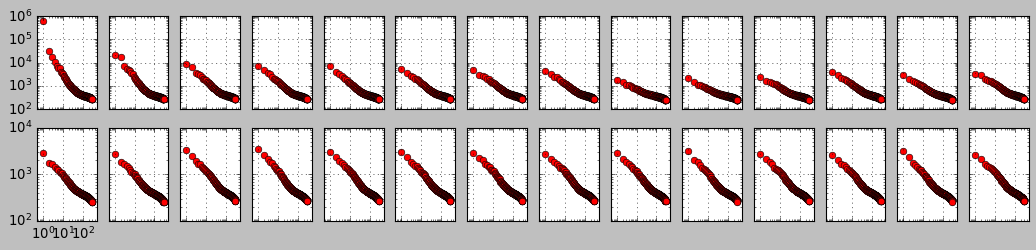

In [103]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 3.2))
for i in range(28):
    ax = fig.add_subplot(2, 14, i + 1)
    plt.style.use('classic')
    plt.plot(np.arange(1, sv[:, i].shape[0] + 1), sv[:, i], 'o', color = 'red')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.5, 500)
    plt.grid()
    if i == 0:
        ax.set_xticklabels([])
    if i % 14 != 0:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    if i < 14:
        plt.ylim(10 ** 2, 10 ** 6)
    else:
        plt.ylim(10 ** 2, 10 ** 4)
plt.show()
fig.savefig("sv_70RM_partition_1.pdf", bbox_inches = 'tight')

In [70]:
import numpy as np
import pandas as pd
np.random.seed(1000)

data = pd.read_csv('../datasets/California-data-set/pems-4w.csv', header = None)
dense_tensor = mat2ten(data.values, np.array([data.values.shape[0], 288, 4 * 7]), 0)
random_matrix = np.random.rand(data.values.shape[0], 4 * 7)

missing_rate = 0.7

### Non-random missing (NM) scenario:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[2]):
        binary_tensor[i1, :, i2] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

del data, random_matrix, binary_tensor

In [71]:
rho = 1e-4
epsilon = 1e-3
maxiter = 100

## Test LSTC-Tubal model
c = 0.001
lambda0 = c * rho
tensor_hat, Phis, sv = imputer(dense_tensor, sparse_tensor, rho, lambda0, epsilon, maxiter)

In [99]:
# np.save('singular_values_70NM_partition_1.npy', sv)
# sv = np.load('singular_values_70NM_partition_1.npy')

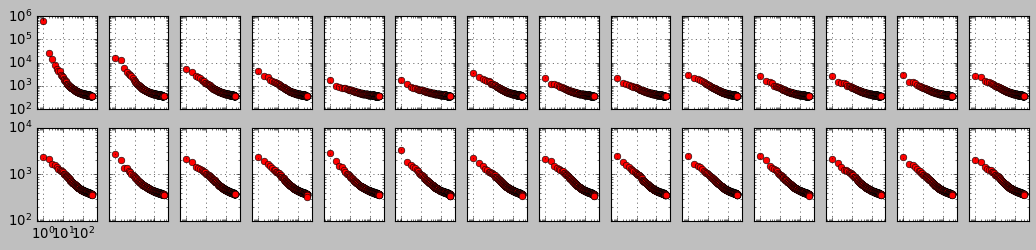

In [101]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 3.2))
for i in range(28):
    ax = fig.add_subplot(2, 14, i + 1)
    plt.style.use('classic')
    plt.plot(np.arange(1, sv[:, i].shape[0] + 1), sv[:, i], 'o', color = 'red')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.5, 500)
    plt.grid()
    if i == 0:
        ax.set_xticklabels([])
    if i % 14 != 0:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    if i < 14:
        plt.ylim(10 ** 2, 10 ** 6)
    else:
        plt.ylim(10 ** 2, 10 ** 4)
plt.show()
fig.savefig("sv_70NM_partition_1.pdf", bbox_inches = 'tight')

In [76]:
import numpy as np
import pandas as pd
np.random.seed(1000)

data = pd.read_csv('../datasets/California-data-set/pems-4w.csv', header = None)
dense_tensor = mat2ten(data.values, np.array([data.values.shape[0], 288, 4 * 7]), 0)
random_tensor = np.random.rand(data.values.shape[0], 288, 4 * 7)

missing_rate = 0.7

### Random missing (RM)
sparse_tensor = dense_tensor * np.round(random_tensor + 0.5 - missing_rate)
del data, random_tensor

In [80]:
rho = 1e-2
epsilon = 1e-3
c = 1e-1
maxiter = 100

i = 6
lambda0 = c * rho
tensor_hat = np.zeros(dense_tensor.shape)
road = graph_pems.values[:, i - 1]
sv = np.zeros((288, 28, 2 ** i))
for d in range(2 ** i):
    pos = np.where(road == d)
    dense = dense_tensor[pos[0], :, :]
    sparse = sparse_tensor[pos[0], :, :]
    small_tensor, _, temp = imputer(dense, sparse, rho, lambda0, epsilon, maxiter)
    tensor_hat[pos[0], :, :] = small_tensor
    sv[: temp.shape[0], :, d] = temp

In [93]:
# np.save('singular_values_70RM_partition_64.npy', sv)
# sv = np.load('singular_values_70RM_partition_64.npy')

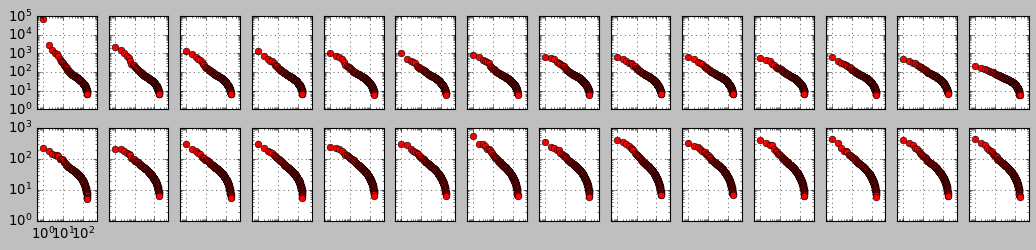

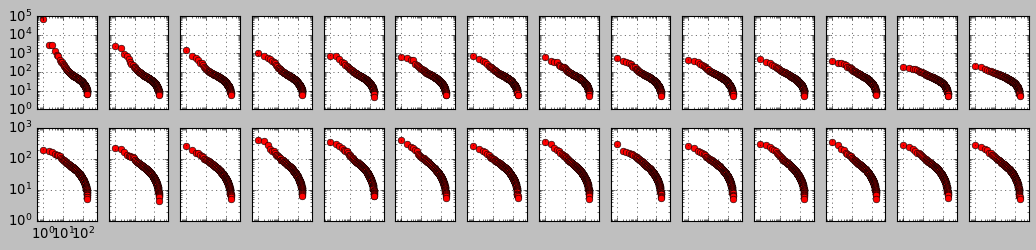

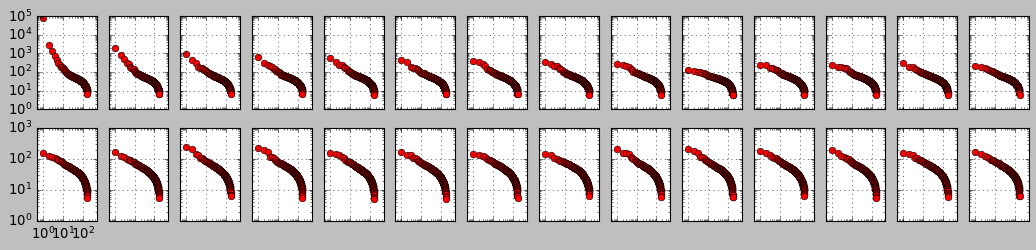

In [95]:
import matplotlib.pyplot as plt

for part in range(3):
    fig = plt.figure(figsize = (16, 3.2))
    for i in range(28):
        ax = fig.add_subplot(2, 14, i + 1)
        plt.style.use('classic')
        pos = np.where(sv[:, i, part] > 0)
        plt.plot(pos[0] + 1, sv[pos[0], i, part], 'o', color = 'red')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(0.5, 500)
        plt.grid()
        if i == 0:
            ax.set_xticklabels([])
        if i % 14 != 0:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        if i < 14:
            plt.ylim(10 ** 0, 10 ** 5)
        else:
            plt.ylim(10 ** 0, 10 ** 3)
    plt.show()
    fig.savefig("sv_70RM_partition_64_{}.pdf".format(part + 1), bbox_inches = 'tight')

In [87]:
import numpy as np
import pandas as pd
np.random.seed(1000)

data = pd.read_csv('../datasets/California-data-set/pems-4w.csv', header = None)
dense_tensor = mat2ten(data.values, np.array([data.values.shape[0], 288, 4 * 7]), 0)
random_matrix = np.random.rand(data.values.shape[0], 4 * 7)

missing_rate = 0.7

### Non-random missing (NM) scenario:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[2]):
        binary_tensor[i1, :, i2] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

del data, random_matrix, binary_tensor

In [88]:
rho = 1e-3
epsilon = 1e-3
c = 1e-2
maxiter = 100

i = 6
lambda0 = c * rho
tensor_hat = np.zeros(dense_tensor.shape)
road = graph_pems.values[:, i - 1]
sv = np.zeros((288, 28, 2 ** i))
for d in range(2 ** i):
    pos = np.where(road == d)
    dense = dense_tensor[pos[0], :, :]
    sparse = sparse_tensor[pos[0], :, :]
    small_tensor, _, temp = imputer(dense, sparse, rho, lambda0, epsilon, maxiter)
    tensor_hat[pos[0], :, :] = small_tensor
    sv[: temp.shape[0], :, d] = temp

In [96]:
# np.save('singular_values_70NM_partition_64.npy', sv)
# sv = np.load('singular_values_70NM_partition_64.npy')

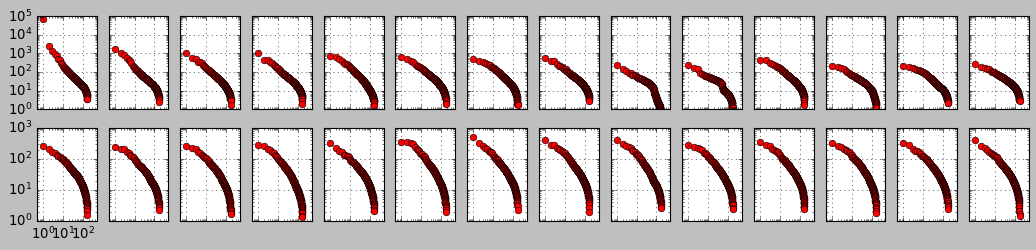

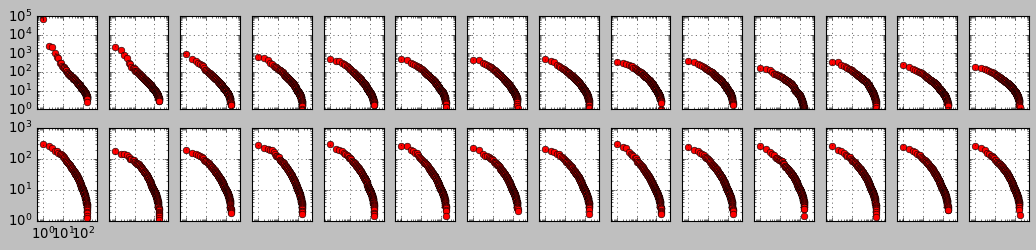

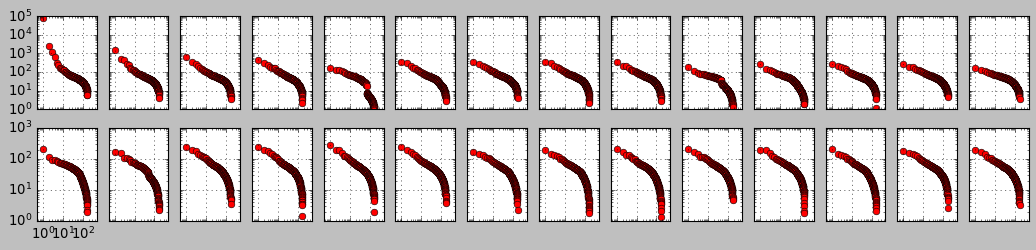

In [97]:
import matplotlib.pyplot as plt

for part in range(3):
    fig = plt.figure(figsize = (16, 3.2))
    for i in range(28):
        ax = fig.add_subplot(2, 14, i + 1)
        plt.style.use('classic')
        pos = np.where(sv[:, i, part] > 0)
        plt.plot(pos[0] + 1, sv[pos[0], i, part], 'o', color = 'red')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(0.5, 500)
        plt.grid()
        if i == 0:
            ax.set_xticklabels([])
        if i % 14 != 0:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        if i < 14:
            plt.ylim(10 ** 0, 10 ** 5)
        else:
            plt.ylim(10 ** 0, 10 ** 3)
    plt.show()
    fig.savefig("sv_70NM_partition_64_{}.pdf".format(part + 1), bbox_inches = 'tight')

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>